<a href="https://colab.research.google.com/github/kalyan8324/kaggile/blob/main/heart_disease_Logistic_Regression_and_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-disease-prediction-using-logistic-regression:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F222487%2F478477%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T121025Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a0c544aad733d63e46394784904960f048e03b4c1e07469101a3cf041965abe16d3de18d4609487db27a8b37bbd7a8b0653ff6b789335a07f5f6820e41c528d0818cb204937c6ade0713e341a03256256268966e1736c3abe8de0b80b25a0f8c2038e0093a9aa41bf673339484ac3465cd8ce2791349bd801b67451f1463ece90f99dd0b383650895e7af9351a9ef2135d8bb39e55a653828a50bfd614c5810b6d02b93128434ae8b4cad6b7328a6c47e78f98de54db1de7a97df7ae5532087792bd2e31745ab3806128f9f8d24ccf57b60ec82a993035eb0a2afc4b4695aa1d12d06779d388d3753a9e73817bec204f6e96dd2a5e52308bca9fe076e357850'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score , confusion_matrix
#  load the data sets
data = pd.read_csv('/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv')
data.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
heart_data = data.drop('education', axis=1)
# data cleaning
heart_data['BMI'] = heart_data['BMI'].fillna(heart_data['BMI'].median())
heart_data['glucose'] = heart_data['glucose'].fillna(heart_data['glucose'].median())
heart_data['heartRate'] = heart_data['heartRate'].fillna(heart_data['heartRate'].median())
heart_data['BPMeds'] = heart_data['BPMeds'].fillna(heart_data['BPMeds'].median())
heart_data['totChol'] = heart_data['totChol'].fillna(heart_data['totChol'].median())
heart_data['cigsPerDay'] = heart_data['cigsPerDay'].fillna(0)
# checking any null values
# heart_data.isnull().sum()

# splitting data into dependent variables and in dependent variables
X= heart_data.drop(['TenYearCHD'],axis=1)
y= heart_data['TenYearCHD']


female_count = heart_data[heart_data['male'] == 1].shape[0]
male_count = heart_data[heart_data['male'] == 0].shape[0]
print(f"Males: {male_count}")
print(f"Females: {female_count}")


Males: 2419
Females: 1819


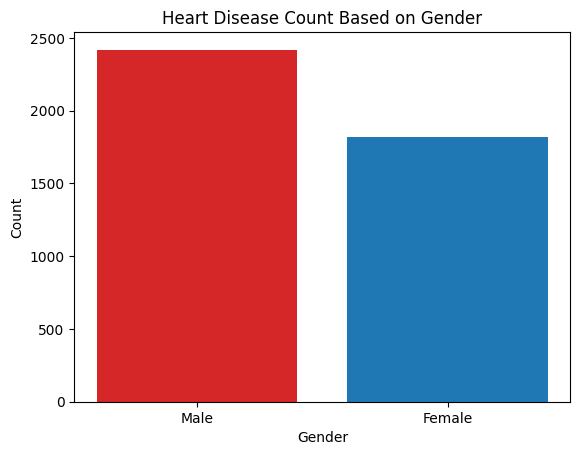

In [ ]:
fig,ax = plt.subplots()

gender_counts = [male_count,female_count]
bar_labels = ['Male', 'Female']
bar_colors = ['tab:red', 'tab:blue']

bars = ax.bar(bar_labels, gender_counts, color=bar_colors)
ax.set_ylabel('Count')
ax.set_xlabel("Gender")
ax.set_title('Heart Disease Count Based on Gender')
# ax.legend([bars])
plt.show()

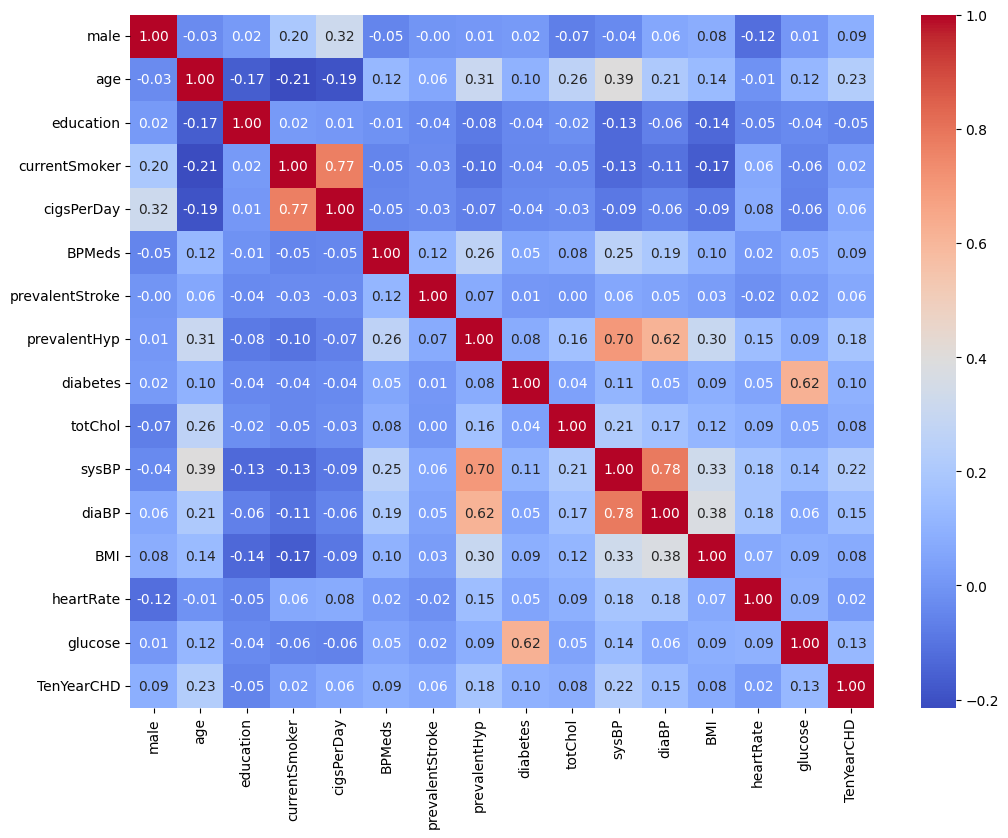

In [ ]:
#  HeatMap
plt.figure(figsize=(12,9))
sns.heatmap(data.corr(),annot = True,cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
#  splitting data into training set and test
X_train , X_test, y_train , y_test =train_test_split(X,y,test_size=0.2,random_state=27)

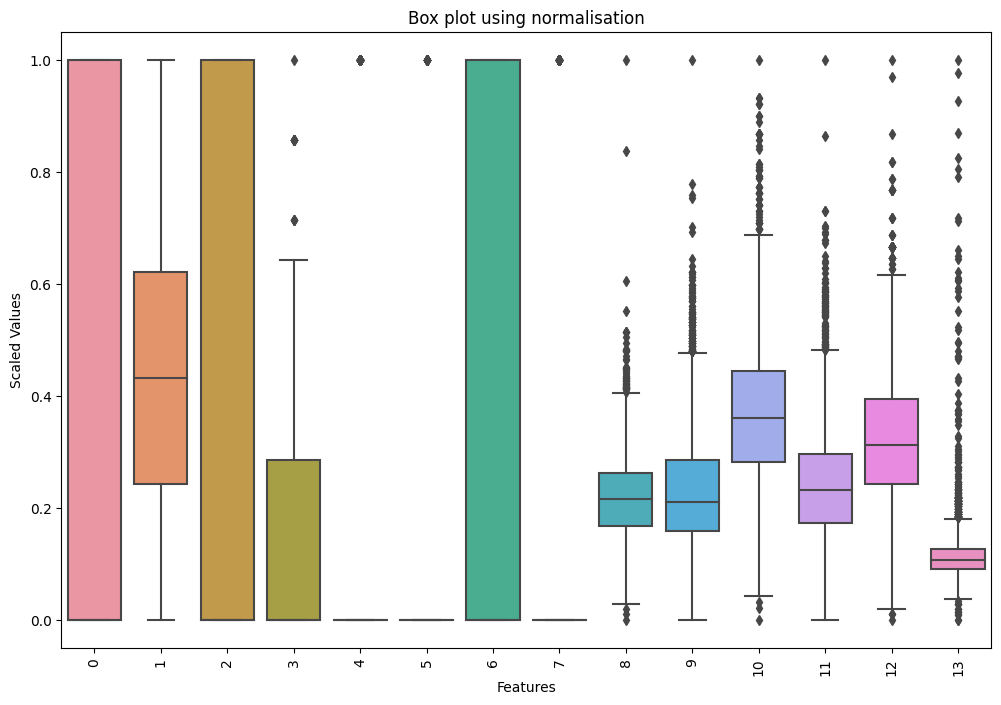

In [ ]:
import seaborn as sns
#  MIN_MAX_SCALLER OR NORMALISATION
# using MinMax Scaller feature Engineering
# fit the scaler on training data
norm = MinMaxScaler().fit(X_train)
#  training data
X_train_norm = norm.transform(X_train)
#  test data
X_test_norm = norm.transform(X_test)
#  creating Box plot

plt.figure(figsize=(12,8))
sns.boxplot(data=X_train_norm)
plt.title("Box plot using normalisation")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.xticks(rotation=90)
plt.show()


In [ ]:

# prediction using sklearn model Logistic regression
model = LogisticRegression()
# data fitting into model
model.fit(X_train_norm,y_train)
#  pred model
pred = model.predict(X_test_norm)
#  test model using accuracy_score
accuracy_test = accuracy_score(y_test,pred)
accuracy_test

0.8608490566037735

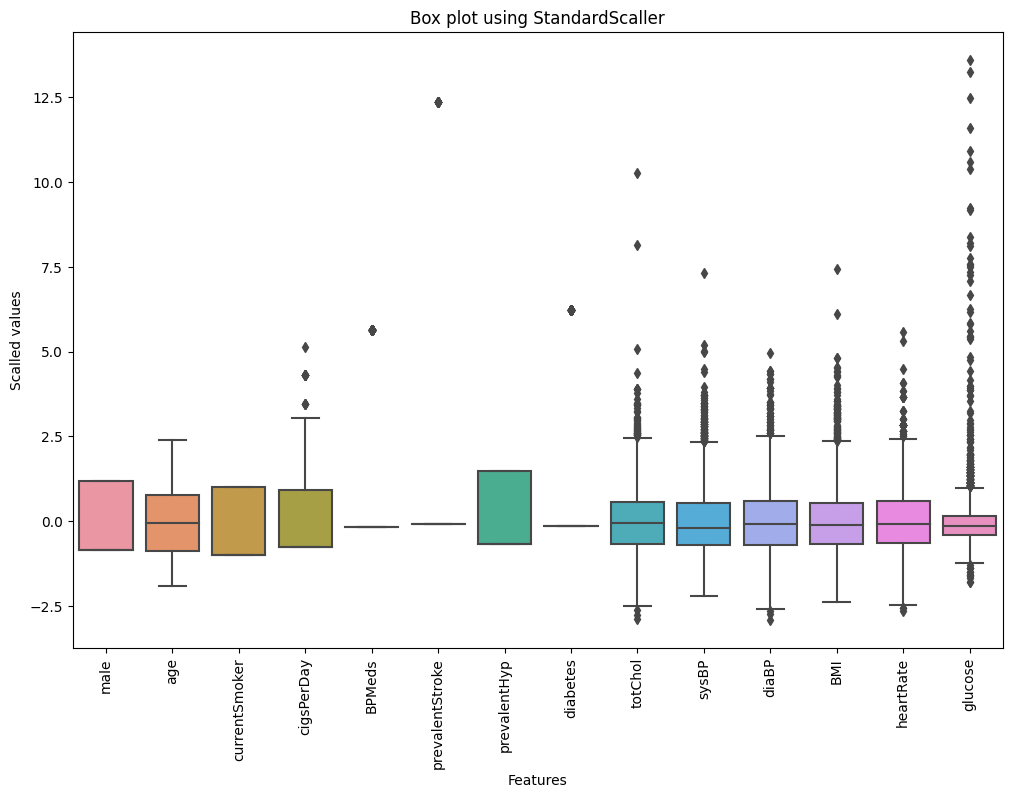

In [ ]:
#  Using Sdandard Scaller
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# print(X.columns)
for i in X.columns:
    scale  = StandardScaler().fit(X_train_stand[[i]])
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

# Box plot using standard scaller
plt.figure(figsize=(12,8))
sns.boxplot(data=X_train_stand)
plt.title("Box plot using StandardScaller")
plt.xlabel("Features")
plt.ylabel("Scalled values")
plt.xticks(rotation=90)
plt.show()

In [ ]:
#  using Logistic Regression
model_sc = LogisticRegression()
model_sc.fit(X_train_stand,y_train)
pred_scal = model_sc.predict(X_test_stand)
accuracy_scale = accuracy_score(y_test,pred_scal)
print(accuracy_scale)

0.8573113207547169


In [ ]:
# With out using scalling
import numpy as np

model_r = LogisticRegression(max_iter=2000)
model_r.fit(X_train.to_numpy(), y_train)
predict_n = model_r.predict(X_test.to_numpy())
accuracy_norm = accuracy_score(y_test, predict_n)
print(accuracy_norm)

0.8573113207547169


Manual Logistic Regression

In [ ]:
# manual Logistic Regression
import numpy as np

# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def sigmoid(x):
#     if np.any(x >= 0):
#         return 1 / (1 + np.exp(-x))
#     else:
#         exp_x = np.exp(x)
#         return exp_x / ( 1 + exp_x)
# coef = model.coef_
# intercept = model.intercept_
#  clip values range prevent the that prevent extrime values
def sigmoid(x):
    # Clip values to prevent overflow
    x_clipped = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x_clipped))


In [ ]:
# Manual Logistic Regression
def manual_Logistic_Regression(X, y, num_iter=2000, learning_rate=0.01):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    # Gradient Descent
    for _ in range(num_iter):
        # Compute Linear Model
        linear_model = np.dot(X, weights) + bias
        # Apply Sigmoid function
        y_pred = sigmoid(linear_model)
        # Compute the gradients
        dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
        db = (1 / n_samples) * np.sum(y_pred - y)
        # Update parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db
    return weights, bias

#  train the manual logistic Regression model
weights_manual, bias_manual = manual_Logistic_Regression(X_train, y_train)
weights_manual

array([ 0.17909284,  1.24114155, -0.05409774,  1.0546572 ,  0.0686884 ,
        0.02667841,  0.37108562,  0.06174193, -1.00252356,  1.11128671,
       -2.1376243 , -1.37195627, -1.8773473 ,  0.09551023])

In [ ]:
linear_model_manual = np.dot(X_test , weights_manual) + bias_manual
y_predicted_manual = sigmoid(linear_model_manual) >= 0.5
manual_accuracy = accuracy_score(y_test,y_predicted_manual)
manual_accuracy

0.8514150943396226